In [1]:
import os
import math
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import imgaug as ia
import cv2 as cv
import pandas as pd

from tensorflow.python.client import device_lib
from imgaug import augmenters as iaa
from imgaug import BoundingBox, BoundingBoxesOnImage
from glob import glob
from tqdm import tqdm



%matplotlib inline

np.random.seed(1)


# Directory constants
DATASET = './dataset'
RESULTS = './results'

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print('\nSetup complete!')

Num GPUs Available:  1

Setup complete!


In [4]:
from tensorflow.keras.applications import resnet50
from tensorflow.keras.layers import Input, Lambda, MaxPooling2D, Conv2D, Reshape, Concatenate, Activation, Add
from tensorflow.keras.models import Model

experiment_name = 'baseline'
batch_size = 2

class SubParts_SSD:
    def __init__(self):
        pass

    def build_anchors(self):
        img_height, img_width = self.input_shape[:2]

        self.anchor_cx = []
        self.anchor_cy = []
        self.anchor_width = []
        self.anchor_height = []

        for i in range(self.num_scales):
            tensor_height, tensor_width = self.tensor_sizes[i]
            horizontal_stride = float(img_width) / tensor_width
            vertical_stride = float(img_height) / tensor_height

            cols, rows = np.meshgrid(range(tensor_width), range(tensor_width))
            cx = (cols + 0.5) * horizontal_stride
            cy = (rows + 0.5) * vertical_stride
            cx = np.expand_dims(cx, axis = -1)
            cy = np.expand_dims(cy, axis = -1)
            cx = np.repeat(cx, self.boxes_per_cell, axis = -1)
            cy = np.repeat(cy, self.boxes_per_cell, axis = -1)

            width = np.zeros_like(cx)
            height = np.zeros_like(cx)
            for j, ar in enumerate(self.aspect_ratios):
                width[...,j] = img_width * self.scales[i] * math.sqrt(ar)
                height[...,j] = img_height * self.scales[i] / math.sqrt(ar)
            width[...,-1] = img_width * math.sqrt(self.scales[i] * self.scales[i+1])
            height[...,-1] = img_height * math.sqrt(self.scales[i] * self.scales[i+1])

            self.anchor_cx.append(cx.reshape((-1,)))
            self.anchor_cy.append(cy.reshape((-1,)))
            self.anchor_width.append(width.reshape((-1,)))
            self.anchor_height.append(height.reshape((-1,)))

        self.anchor_cx = np.concatenate(self.anchor_cx)
        self.anchor_cy = np.concatenate(self.anchor_cy)
        self.anchor_width = np.concatenate(self.anchor_width)
        self.anchor_height = np.concatenate(self.anchor_height)

        self.anchor_xmin = self.anchor_cx - self.anchor_width * 0.5
        self.anchor_ymin = self.anchor_cy - self.anchor_height * 0.5
        self.anchor_xmax = self.anchor_cx + self.anchor_width * 0.5
        self.anchor_ymax = self.anchor_cy + self.anchor_height * 0.5


    def build_subpart_anchors(self):
        img_height, img_width = self.input_shape[:2]

        self.subparts_anchor_cx = []
        self.subparts_anchor_cy = []
        self.subparts_anchor_width = []
        self.subparts_anchor_height = []

        for i in range(self.num_subparts_scales):
            tensor_height, tensor_width = self.subparts_tensor_sizes[i]
            horizontal_stride = float(img_width) / tensor_width
            vertical_stride = float(img_height) / tensor_height

            cols, rows = np.meshgrid(range(tensor_width), range(tensor_width))
            cx = (cols + 0.5) * horizontal_stride
            cy = (rows + 0.5) * vertical_stride
            cx = np.expand_dims(cx, axis = -1)
            cy = np.expand_dims(cy, axis = -1)
            cx = np.repeat(cx, self.subparts_boxes_per_cell, axis = -1)
            cy = np.repeat(cy, self.subparts_boxes_per_cell, axis = -1)

            width = np.zeros_like(cx)
            height = np.zeros_like(cx)
            for j, ar in enumerate(self.subparts_aspect_ratios):
                width[...,j] = img_width * self.subparts_scales[i] * math.sqrt(ar)
                height[...,j] = img_height * self.subparts_scales[i] / math.sqrt(ar)
            width[...,-1] = img_width * math.sqrt(self.subparts_scales[i] * self.subparts_scales[i+1])
            height[...,-1] = img_height * math.sqrt(self.subparts_scales[i] * self.subparts_scales[i+1])

            self.subparts_anchor_cx.append(cx.reshape((-1,)))
            self.subparts_anchor_cy.append(cy.reshape((-1,)))
            self.subparts_anchor_width.append(width.reshape((-1,)))
            self.subparts_anchor_height.append(height.reshape((-1,)))

        self.subparts_anchor_cx = np.concatenate(self.subparts_anchor_cx)
        self.subparts_anchor_cy = np.concatenate(self.subparts_anchor_cy)
        self.subparts_anchor_width = np.concatenate(self.subparts_anchor_width)
        self.subparts_anchor_height = np.concatenate(self.subparts_anchor_height)

        self.subparts_anchor_xmin = self.subparts_anchor_cx - self.subparts_anchor_width * 0.5
        self.subparts_anchor_ymin = self.subparts_anchor_cy - self.subparts_anchor_height * 0.5
        self.subparts_anchor_xmax = self.subparts_anchor_cx + self.subparts_anchor_width * 0.5
        self.subparts_anchor_ymax = self.subparts_anchor_cy + self.subparts_anchor_height * 0.5

class SubParts_SSD_PPN_ResNet50(SubParts_SSD):
    def __init__(self,
                class_labels,
                subparts_class_labels,
                input_shape = (300,300,3),
                scales = [0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05],
                aspect_ratios = [1.0/3.0, 0.5, 1.0, 2.0, 3.0],
                subparts_scales = 0.25,
                subparts_aspect_ratios = [1.0/3.0, 0.5, 1.0, 2.0, 3.0]):

        if isinstance(class_labels, str):
            with open(class_labels, 'r') as f:
                class_labels = [line.strip() for line in f]

        if isinstance(subparts_class_labels, str):
            with open(subparts_class_labels, 'r') as f:
                subparts_class_labels = [line.strip() for line in f]

        if not 'background' in class_labels:
            class_labels = ['background'] + class_labels

        if not 'background' in subparts_class_labels:
            subparts_class_labels = ['background'] + subparts_class_labels

        self.class_labels = class_labels
        self.subparts_class_labels = subparts_class_labels

        self.num_classes = len(class_labels)
        self.num_subpart_classes = len(subparts_class_labels)

        self.background_id = class_labels.index('background')
        self.subparts_background_id = subparts_class_labels.index('background')

        self.input_shape = input_shape

        self.scales = scales
        self.num_scales = len(scales) - 1
        self.aspect_ratios = aspect_ratios
        self.boxes_per_cell = len(aspect_ratios) + 1

        if not isinstance(subparts_scales, list):
            subparts_scales = [s * subparts_scales for s in scales]

        self.subparts_scales = subparts_scales
        self.num_subparts_scales = len(subparts_scales) - 1
        self.subparts_aspect_ratios = subparts_aspect_ratios
        self.subparts_boxes_per_cell = len(subparts_aspect_ratios) + 1

        self.build_model()
        self.build_anchors()
        self.build_subpart_anchors()

    def build_model(self):
        input = Input(shape=self.input_shape)
        preprocessed_input = Lambda(lambda x: resnet50.preprocess_input(x), name='preprocess')(input)

        base = resnet50.ResNet50(include_top=False, weights='imagenet', input_tensor=preprocessed_input)
        featmap = base.get_layer('conv4_block3_2_relu').output

        feature_maps = [featmap]

        featmap_height, featmap_width = featmap.shape.as_list()[1:3]
        self.feature_map_sizes = [(featmap_height, featmap_width)]

        while len(feature_maps) < self.num_scales:
            featmap = MaxPooling2D(pool_size = (2, 2), padding = 'same', batch_generator_trainname='subparts_max_pool_%d' % len(feature_maps))(featmap)
            feature_maps.append(featmap)

            featmap_height, featmap_width = featmap.shape.as_list()[1:3]
            self.feature_map_sizes.append((featmap_height, featmap_width))

        # Sub parts detection parameters

        subparts_shared_conv = Conv2D(filters = 512,
                            kernel_size = (1, 1),
                            strides = (1, 1),
                            activation = 'relu',
                            name = 'subparts_shared_conv')

        subparts_box_classifier = Conv2D(filters = self.subparts_boxes_per_cell * self.num_subpart_classes,
                                kernel_size = (3, 3),
                                strides = (1, 1),
                                padding = 'same',
                                activation = 'linear',
                                name = 'subparts_box_classifier')

        subparts_box_regressor = Conv2D(filters = self.subparts_boxes_per_cell * 4,
                                kernel_size = (3, 3),
                                strides = (1, 1),
                                padding = 'same',
                                activation = 'linear',
                                name = 'subparts_box_regressor')

        subparts_cls_output = []
        subparts_loc_output = []
        subparts_featmaps = []
        self.subparts_tensor_sizes = []

        for featmap, featmap_size in zip(feature_maps, self.feature_map_sizes):
            featmap = subparts_shared_conv(featmap)
            cls = subparts_box_classifier(featmap)
            loc = subparts_box_regressor(featmap)

            featmap_height, featmap_width = featmap_size
            cls = Reshape((featmap_height, featmap_width, self.subparts_boxes_per_cell, self.num_subpart_classes))(cls)
            cls = Activation('softmax')(cls)
            cls = Reshape((featmap_height, featmap_width, self.subparts_boxes_per_cell * self.num_subpart_classes))(cls)

            subparts_featmaps.append(Concatenate(axis=-1)([cls, loc]))

            self.subparts_tensor_sizes.append(featmap_size)
            total_boxes = featmap_size[0] * featmap_size[1] * self.subparts_boxes_per_cell

            cls = Reshape((total_boxes, self.num_subpart_classes))(cls)
            loc = Reshape((total_boxes, 4))(loc)

            subparts_cls_output.append(cls)
            subparts_loc_output.append(loc)

        subparts_cls_output = Concatenate(axis = 1)(subparts_cls_output)
        subparts_loc_output = Concatenate(axis = 1)(subparts_loc_output)
        subparts_output = Concatenate(axis = -1, name='subparts_output')([subparts_cls_output, subparts_loc_output])

        featmap = base.get_layer('conv4_block6_out').output

        feature_maps = [featmap]

        featmap_height, featmap_width = featmap.shape.as_list()[1:3]
        self.feature_map_sizes = [(featmap_height, featmap_width)]

        while len(feature_maps) < self.num_scales:
            featmap = MaxPooling2D(pool_size = (2, 2), padding = 'same', name='max_pool_%d' % len(feature_maps))(featmap)
            feature_maps.append(featmap)

            featmap_height, featmap_width = featmap.shape.as_list()[1:3]
            self.feature_map_sizes.append((featmap_height, featmap_width))

        # Full object detection parameters

        shared_conv = Conv2D(filters = 512,
                            kernel_size = (1, 1),
                            strides = (1, 1),
                            activation = 'relu',
                            name = 'shared_conv')

        box_classifier = Conv2D(filters = self.boxes_per_cell * self.num_classes,
                                kernel_size = (3, 3),
                                strides = (1, 1),
                                padding = 'same',
                                activation = 'linear',
                                name = 'box_classifier')

        box_regressor = Conv2D(filters = self.boxes_per_cell * 4,
                                kernel_size = (3, 3),
                                strides = (1, 1),
                                padding = 'same',
                                activation = 'linear',
                                name = 'box_regressor')

        cls_output = []
        loc_output = []
        self.tensor_sizes = []

        for featmap, subparts_featmap, featmap_size in zip(feature_maps, subparts_featmaps, self.feature_map_sizes):
            featmap = Concatenate(axis = -1)([shared_conv(featmap), subparts_featmap])
            #featmap = shared_conv(featmap)
            cls = box_classifier(featmap)
            loc = box_regressor(featmap)

            self.tensor_sizes.append(featmap_size)
            total_boxes = featmap_size[0] * featmap_size[1] * self.boxes_per_cell

            cls = Reshape((total_boxes, self.num_classes))(cls)
            cls = Activation('softmax')(cls)
            loc = Reshape((total_boxes, 4))(loc)

            cls_output.append(cls)
            loc_output.append(loc)

        cls_output = Concatenate(axis = 1)(cls_output)
        loc_output = Concatenate(axis = 1)(loc_output)
        output = Concatenate(axis = -1, name='main_output')([cls_output, loc_output])

        self.model = Model(input, [subparts_output, output])
        #self.model.summary()



# Sometimes(0.5, ...) applies the given augmenter in 50% of all cases,
# e.g. Sometimes(0.5, GaussianBlur(0.3)) would blur roughly every second
# image.
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

# Define our sequence of augmentation steps that will be applied to every image.
augmentation_seq = iaa.Sequential(
    [
        #
        # Apply the following augmenters to most images.
        #
        iaa.Fliplr(0.5), # horizontally flip 50% of all images
        iaa.Flipud(0.2), # vertically flip 20% of all images

        # crop some of the images by 0-10% of their height/width
        sometimes(iaa.Crop(percent=(0, 0.1))),

        # Apply affine transformations to some of the images
        # - scale to 80-120% of image height/width (each axis independently)
        # - translate by -20 to +20 relative to height/width (per axis)
        # - rotate by -45 to +45 degrees
        # - shear by -16 to +16 degrees
        # - order: use nearest neighbour or bilinear interpolation (fast)
        # - mode: use any available mode to fill newly created pixels
        #         see API or scikit-image for which modes are available
        # - cval: if the mode is constant, then use a random brightness
        #         for the newly created pixels (e.g. sometimes black,
        #         sometimes white)
        sometimes(iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
            rotate=(-45, 45),
            shear=(-16, 16),
            order=[0, 1],
            cval=(0, 255),
            mode=ia.ALL
        )),

        #
        # Execute 0 to 5 of the following (less important) augmenters per
        # image. Don't execute all of them, as that would often be way too
        # strong.
        #
        iaa.SomeOf((0, 5),
            [
                # Convert some images into their superpixel representation,
                # sample between 20 and 200 superpixels per image, but do
                # not replace all superpixels with their average, only
                # some of them (p_replace).
                sometimes(
                    iaa.Superpixels(
                        p_replace=(0, 1.0),
                        n_segments=(20, 200)
                    )
                ),

                # Blur each image with varying strength using
                # gaussian blur (sigma between 0 and 3.0),
                # average/uniform blur (kernel size between 2x2 and 7x7)
                # median blur (kernel size between 3x3 and 11x11).
                iaa.OneOf([
                    iaa.GaussianBlur((0, 3.0)),
                    iaa.AverageBlur(k=(2, 7)),
                    iaa.MedianBlur(k=(3, 11)),
                ]),

                # Sharpen each image, overlay the result with the original
                # image using an alpha between 0 (no sharpening) and 1
                # (full sharpening effect).
                iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)),

                # Same as sharpen, but for an embossing effect.
                iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)),

                # Search in some images either for all edges or for
                # directed edges. These edges are then marked in a black
                # and white image and overlayed with the original image
                # using an alpha of 0 to 0.7.
                sometimes(iaa.OneOf([
                    iaa.EdgeDetect(alpha=(0, 0.7)),
                    iaa.DirectedEdgeDetect(
                        alpha=(0, 0.7), direction=(0.0, 1.0)
                    ),
                ])),

                # Add gaussian noise to some images.
                # In 50% of these cases, the noise is randomly sampled per
                # channel and pixel.
                # In the other 50% of all cases it is sampled once per
                # pixel (i.e. brightness change).
                iaa.AdditiveGaussianNoise(
                    loc=0, scale=(0.0, 0.05*255), per_channel=0.5
                ),

                # Either drop randomly 1 to 10% of all pixels (i.e. set
                # them to black) or drop them on an image with 2-5% percent
                # of the original size, leading to large dropped
                # rectangles.
                iaa.OneOf([
                    iaa.Dropout((0.01, 0.1), per_channel=0.5),
                    iaa.CoarseDropout(
                        (0.03, 0.15), size_percent=(0.02, 0.05),
                        per_channel=0.2
                    ),
                ]),

                # Invert each image's chanell with 5% probability.
                # This sets each pixel value v to 255-v.
                iaa.Invert(0.05, per_channel=True), # invert color channels

                # Add a value of -10 to 10 to each pixel.
                iaa.Add((-10, 10), per_channel=0.5),

                # Change brightness of images (50-150% of original value).
                iaa.Multiply((0.5, 1.5), per_channel=0.5),

                # Improve or worsen the contrast of images.
                iaa.contrast.LinearContrast((0.5, 2.0), per_channel=0.5),

                # Convert each image to grayscale and then overlay the
                # result with the original with random alpha. I.e. remove
                # colors with varying strengths.
                iaa.Grayscale(alpha=(0.0, 1.0)),

                # In some images move pixels locally around (with random
                # strengths).
                sometimes(
                    iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)
                ),

                # In some images distort local areas with varying strength.
                sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05)))
            ],
            # do all of the above augmentations in random order
            random_order=True
        )
    ],
    # do all of the above augmentations in random order
    random_order=True
)

class BoundingBox(ia.BoundingBox):
    """
    Extend the imgaug.BoundingBox class with the
        addition of a confidence attribute.
    """
    def __init__(self, x1, y1, x2, y2, label = None, confidence = 1.0):
        if x1 > x2:
            x2, x1 = x1, x2
        ia.do_assert(x2 >= x1)
        if y1 > y2:
            y2, y1 = y1, y2
        ia.do_assert(y2 >= y1)

        self.x1 = x1
        self.y1 = y1
        self.x2 = x2
        self.y2 = y2
        self.label = label
        self.confidence = confidence

    # Aparently, there is a bug on the iou method on the pip3 version of imgaug.
    # So I copied this implementation from the latest version of code on GitHub.
    def iou(self, other):
        """
        Compute the IoU of this bounding box with another one.
        IoU is the intersection over union, defined as::
            ``area(intersection(A, B)) / area(union(A, B))``
            ``= area(intersection(A, B)) / (area(A) + area(B) - area(intersection(A, B)))``
        Parameters
        ----------
        other : imgaug.BoundingBox
            Other bounding box with which to compare.
        Returns
        -------
        float
            IoU between the two bounding boxes.
        """
        inters = self.intersection(other)
        if inters is None:
            return 0.0
        else:
            area_union = self.area + other.area - inters.area
            return inters.area / area_union if area_union > 0 else 0.0
    
    def __repr__(self):
        return self.__str__()

    def __str__(self):
        return "BoundingBox(x1=%.4f, y1=%.4f, x2=%.4f, y2=%.4f, label=%s, confidence=%.4f)" % (
            self.x1, self.y1, self.x2, self.y2, str(self.label), self.confidence)

def maybe_load(image):
    if isinstance(image, str):
        image_file = image
        if not os.path.exists(image_file):
            raise Exception('Image not found: %s' % image_file)
        else:
            image = cv.imread(image_file)
            if image is None:
                raise Exception('Error loading image: %s' % image_file)
    return image

def display_image(image, channels = 'rgb'):
    image = maybe_load(image)

    channels = channels.lower()
    if channels == 'bgr':
        pass
    elif channels == 'rgb':
        image = image[..., [2,1,0]]
    else:
        raise Exception('Channels format not supported: %s' % channels)

    cv.imshow('Image', image)
    cv.waitKey(0)
    cv.destroyAllWindows()



def IoU(xmin1, ymin1, xmax1, ymax1, xmin2, ymin2, xmax2, ymax2):
    intersection_width  = np.maximum(0.0, np.minimum(xmax1, xmax2) - np.maximum(xmin1, xmin2))
    intersection_height = np.maximum(0.0, np.minimum(ymax1, ymax2) - np.maximum(ymin1, ymin2))

    intersection = intersection_width * intersection_height
    union = (xmax1 - xmin1)*(ymax1 - ymin1) + (xmax2 - xmin2)*(ymax2 - ymin2) - intersection

    return intersection / union
    
def output_encoder(ground_truth, network, neg_iou_threshold = 0.3, pos_iou_threshold = 0.5):
    anchor_xmin = network.anchor_xmin
    anchor_ymin = network.anchor_ymin
    anchor_xmax = network.anchor_xmax
    anchor_ymax = network.anchor_ymax
    num_anchors = anchor_xmin.shape[0]
    batch_output = []

    # For each item in the batch
    for boxes in ground_truth:
        num_gt = len(boxes.bounding_boxes)
        output = np.zeros((num_anchors, network.num_classes + 4))

        if num_gt == 0:
            output[:, network.background_id] = 1.0
            batch_output.append(output)
            continue

        ious = []

        for box in boxes.bounding_boxes:
            ious.append(IoU(box.x1, box.y1, box.x2, box.y2,
                            anchor_xmin, anchor_ymin, anchor_xmax, anchor_ymax))
        ious = np.array(ious)

        matches = [[] for _ in range(num_gt)]

        def find_best_match_for_gts(ious):
            ious = ious.copy()

            for _ in range(num_gt):
                best_gt = np.argmax(np.max(ious, axis = 1))
                best_anchor = np.argmax(ious[best_gt, :])

                matches[best_gt].append(best_anchor)
                ious[best_gt, :] = -1.0
                ious[:, best_anchor] = -1.0

        def find_best_match_for_anchors(ious):
            for anchor_index in range(num_anchors):
                if ious[0, anchor_index] < 0.0: continue
                best_gt = np.argmax(ious[:, anchor_index])

                if ious[best_gt, anchor_index] >= pos_iou_threshold:
                    matches[best_gt].append(anchor_index)
                elif ious[best_gt, anchor_index] < neg_iou_threshold:
                    output[anchor_index, network.background_id] = 1.0

        find_best_match_for_gts(ious.copy())
        ious[:, [match[0] for match in matches]] = -1.0
        find_best_match_for_anchors(ious)

        for i, box in enumerate(boxes.bounding_boxes):
            box_cx = (box.x1 + box.x2) * 0.5
            box_cy = (box.y1 + box.y2) * 0.5
            box_w = box.x2 - box.x1
            box_h = box.y2 - box.y1

            if box_w < 1.0 or box_h < 1.0: continue

            anchor_cx = network.anchor_cx[matches[i]]
            anchor_cy = network.anchor_cy[matches[i]]
            anchor_w  = network.anchor_width[matches[i]]
            anchor_h  = network.anchor_height[matches[i]]

            output[matches[i], network.class_labels.index(box.label)] = 1.0
            output[matches[i], -4] = (box_cx - anchor_cx) / anchor_w
            output[matches[i], -3] = (box_cy - anchor_cy) / anchor_h
            output[matches[i], -2] = np.log(box_w / anchor_w)
            output[matches[i], -1] = np.log(box_h / anchor_h)

        batch_output.append(output)

    return np.array(batch_output)


def subparts_output_encoder(ground_truth, network, neg_iou_threshold = 0.3, pos_iou_threshold = 0.5):
    anchor_xmin = network.subparts_anchor_xmin
    anchor_ymin = network.subparts_anchor_ymin
    anchor_xmax = network.subparts_anchor_xmax
    anchor_ymax = network.subparts_anchor_ymax
    num_anchors = anchor_xmin.shape[0]
    batch_output = []

    # For each item in the batch
    for boxes in ground_truth:
        num_gt = len(boxes.bounding_boxes)
        output = np.zeros((num_anchors, network.num_subpart_classes + 4))

        if num_gt == 0:
            output[:, network.subparts_background_id] = 1.0
            batch_output.append(output)
            continue

        ious = []

        for box in boxes.bounding_boxes:
            ious.append(IoU(box.x1, box.y1, box.x2, box.y2,
                            anchor_xmin, anchor_ymin, anchor_xmax, anchor_ymax))
        ious = np.array(ious)

        matches = [[] for _ in range(num_gt)]

        def find_best_match_for_gts(ious):
            ious = ious.copy()

            for _ in range(num_gt):
                best_gt = np.argmax(np.max(ious, axis = 1))
                best_anchor = np.argmax(ious[best_gt, :])

                matches[best_gt].append(best_anchor)
                ious[best_gt, :] = -1.0
                ious[:, best_anchor] = -1.0

        def find_best_match_for_anchors(ious):
            for anchor_index in range(num_anchors):
                if ious[0, anchor_index] < 0.0: continue
                best_gt = np.argmax(ious[:, anchor_index])

                if ious[best_gt, anchor_index] >= pos_iou_threshold:
                    matches[best_gt].append(anchor_index)
                elif ious[best_gt, anchor_index] < neg_iou_threshold:
                    output[anchor_index, network.subparts_background_id] = 1.0

        find_best_match_for_gts(ious.copy())
        ious[:, [match[0] for match in matches]] = -1.0
        find_best_match_for_anchors(ious)

        for i, box in enumerate(boxes.bounding_boxes):
            if box.area < 1.0: continue

            box_cx = (box.x1 + box.x2) * 0.5
            box_cy = (box.y1 + box.y2) * 0.5
            box_w = box.x2 - box.x1
            box_h = box.y2 - box.y1

            anchor_cx = network.subparts_anchor_cx[matches[i]]
            anchor_cy = network.subparts_anchor_cy[matches[i]]
            anchor_w  = network.subparts_anchor_width[matches[i]]
            anchor_h  = network.subparts_anchor_height[matches[i]]

            output[matches[i], network.subparts_class_labels.index(box.label)] = 1.0
            output[matches[i], -4] = (box_cx - anchor_cx) / anchor_w
            output[matches[i], -3] = (box_cy - anchor_cy) / anchor_h
            output[matches[i], -2] = np.log(box_w / anchor_w)
            output[matches[i], -1] = np.log(box_h / anchor_h)

        batch_output.append(output)

    return np.array(batch_output)

class SubPartsBatchGenerator:
    def __init__(self,
                 network,
                 dataset = None,
                 subparts_dataset = None,
                 images_dir = None,
                 pickled_dataset = None,
                 channels = 'RGB'):

        self.network = network
        self.images = []
        self.objects = []
        self.subparts = []

        if not dataset is None or not pickled_dataset is None:
            self.add_data(dataset, subparts_dataset, images_dir, pickled_dataset)

    def add_data(self,
                 dataset = None,
                 subparts_dataset = None,
                 images_dir = None,
                 pickled_dataset = None,
                 channels = 'RGB'):

        if not pickled_dataset is None and os.path.exists(pickled_dataset):
            with open(pickled_dataset, 'rb') as f:
                images, objects, subparts = pickle.load(f)

            if images.shape[1:] != self.network.input_shape:
                raise Exception('The shape of the images in %s is '+
                                'not compatible with the network')
        else:
            if dataset is None:
                raise Exception('At least one of dataset or pickled_dataset must be provided')

            if isinstance(dataset, str):
                dataset = pd.read_csv(dataset, dtype={
                                                'image_id': str,
                                                'object_id': str})

            if isinstance(subparts_dataset, str):
                subparts_dataset = pd.read_csv(subparts_dataset, dtype={
                                                                    'image_id': str,
                                                                    'object_id': str})

            input_height, input_width = self.network.input_shape[:2]
            images = {}
            objects = {}
            subparts = {}

            for i in tqdm(range(dataset.shape[0]), desc='Preprocessing Dataset'):
                entry = dataset.loc[i]
                img_id = str(entry['image_id'])
                obj_id = str(entry['object_id'])

                filepath = glob(os.path.join(images_dir, img_id + '*'))[0]
                image_height = entry['image_height']
                image_width = entry['image_width']

                if not img_id in images:
                    #img = img_to_array(load_img(filepath, target_size=(input_height, input_width)))
                    img = cv.resize(cv.imread(filepath), (input_width, input_height))
                    images[img_id] = img
                    objects[img_id] = []
                    subparts[img_id] = []
                    del img

                obj_class = self.network.class_labels.index(entry['class'])
                xmin = entry['xmin'] * float(input_width) / image_width
                ymin = entry['ymin'] * float(input_height) / image_height
                xmax = entry['xmax'] * float(input_width) / image_width
                ymax = entry['ymax'] * float(input_height) / image_height
                objects[img_id].append([obj_class, xmin, ymin, xmax, ymax])

                obj_subparts = subparts_dataset.loc[subparts_dataset['object_id'] == obj_id].reset_index()

                for j in range(len(obj_subparts)):
                    subpart = obj_subparts.loc[j]

                    subpart_class = self.network.subparts_class_labels.index(subpart['class'])
                    xmin = subpart['xmin'] * float(input_width) / image_width
                    ymin = subpart['ymin'] * float(input_height) / image_height
                    xmax = subpart['xmax'] * float(input_width) / image_width
                    ymax = subpart['ymax'] * float(input_height) / image_height
                    subparts[img_id].append([subpart_class, xmin, ymin, xmax, ymax])

            images = np.array(list(images.values()))

            for img_id in objects:
                objects[img_id] = np.array(objects[img_id])
            objects = list(objects.values())

            for img_id in subparts:
                subparts[img_id] = np.array(subparts[img_id])
            subparts = list(subparts.values())

            channels = channels.lower()
            if channels == 'bgr':
                pass
            elif channels == 'rgb':
                images = images[..., [2,1,0]]
            else:
                raise Exception('Channel format not supported: %s' % channels)

            if not pickled_dataset is None:
                with open(pickled_dataset, 'wb') as f:
                    pickle.dump((images, objects, subparts), f)

        if len(self.images) == 0:
            self.images = images
        else:
            self.images = np.concatenate([self.images, images], axis = 0)
        self.objects += objects
        self.subparts += subparts

    def get_generator(self, batch_size = 32,
                      shuffle = False,
                      encode_output = False,
                      augmentation = None):

        def generator(images, objects, subparts):
            batch_start = 0

            if shuffle:
                perm = np.random.permutation(len(images))
                images = images[perm]
                objects = [objects[i] for i in perm]
                subparts = [subparts[i] for i in perm]

            while True:
                if batch_start + batch_size > len(images):
                    if shuffle:
                        perm = np.random.permutation(len(images))
                        images = images[perm]
                        objects = [objects[i] for i in perm]
                        subparts = [subparts[i] for i in perm]
                    batch_start = 0

                batch_X = images[batch_start : batch_start+batch_size]
                batch_y_objects = [
                    ia.BoundingBoxesOnImage([
                        BoundingBox(x1=x1, y1=y1, x2=x2, y2=y2, label=self.network.class_labels[int(label)])
                        for (label, x1, y1, x2, y2) in img_boxes
                    ], shape = self.network.input_shape)
                    for img_boxes in objects[batch_start : batch_start+batch_size]
                ]
                batch_y_subparts = [
                    ia.BoundingBoxesOnImage([
                        BoundingBox(x1=x1, y1=y1, x2=x2, y2=y2, label=self.network.subparts_class_labels[int(label)])
                        for (label, x1, y1, x2, y2) in img_boxes
                    ], shape = self.network.input_shape)
                    for img_boxes in subparts[batch_start : batch_start+batch_size]
                ]
                batch_start += batch_size

                if augmentation:
                    batch_X, batch_y_objects, batch_y_subparts = self.augment(
                        batch_X, batch_y_objects, batch_y_subparts, augmentation)

                if encode_output:
                    batch_y_objects = output_encoder(batch_y_objects, self.network)
                    batch_y_subparts = subparts_output_encoder(batch_y_subparts, self.network)

                batch_y = [batch_y_subparts, batch_y_objects]

                yield batch_X, batch_y

        return generator(self.images, self.objects, self.subparts), len(self.images)


    def augment(self, images, object_boxes, subpart_boxes, augmentation_seq, max_tries = 1):
        for _ in range(max_tries):
            try:
                seq_det = augmentation_seq.to_deterministic()
                _object_boxes = seq_det.augment_bounding_boxes(object_boxes)
                _subpart_boxes = seq_det.augment_bounding_boxes(subpart_boxes)
                _images = seq_det.augment_images(np.copy(images))
                object_boxes = _object_boxes
                subpart_boxes = _subpart_boxes
                images = _images
                break
            except:
                continue

        object_boxes = [img_boxes.remove_out_of_image().clip_out_of_image() for img_boxes in object_boxes]
        subpart_boxes = [img_boxes.remove_out_of_image().clip_out_of_image() for img_boxes in subpart_boxes]

        return images, object_boxes, subpart_boxes


In [5]:
network = SubParts_SSD_PPN_ResNet50(class_labels = ['qr_code'],
                                     subparts_class_labels = ['fip'],
                                     input_shape = (480,480,3))

network.model.summary()

TypeError: ('Keyword argument not understood:', 'batch_generator_trainname')

Preprocessing Dataset: 100%|██████████| 143/143 [00:06<00:00, 23.70it/s]


567 training images
100 validation images
(2, 480, 480, 3)
(2, 7260, 6) (2, 7260, 6)


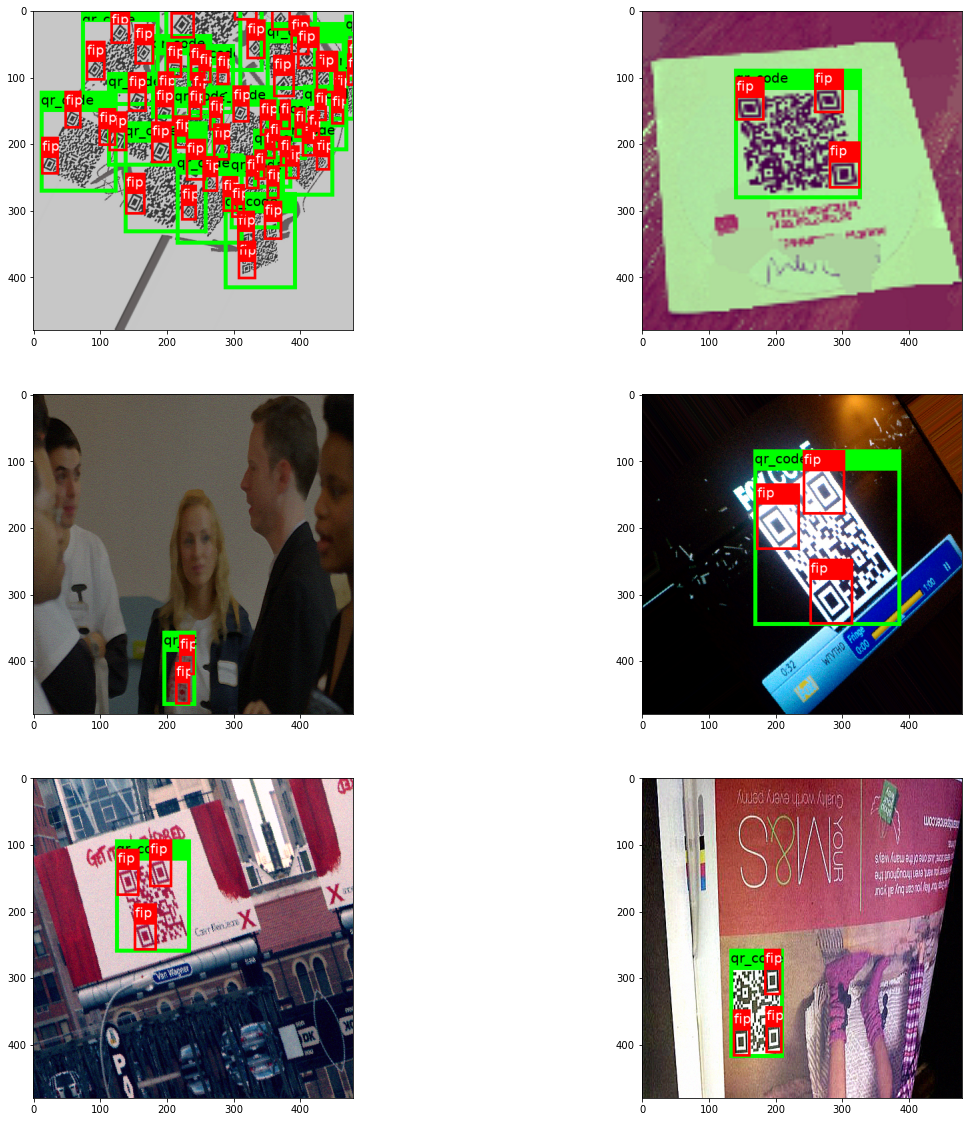

In [4]:

train_qr_codes = pd.read_csv(f'{DATASET}/{experiment_name}/qr_codes_train.csv', dtype={'image_id': str, 'object_id': str})
valid_qr_codes = pd.read_csv(f'{DATASET}/{experiment_name}/qr_codes_valid.csv', dtype={'image_id': str, 'object_id': str})

train_fips = pd.read_csv(f'{DATASET}/{experiment_name}/fips_train.csv', dtype={'image_id': str, 'object_id': str})
valid_fips = pd.read_csv(f'{DATASET}/{experiment_name}/fips_valid.csv', dtype={'image_id': str, 'object_id': str})

batch_generator_train = SubPartsBatchGenerator(network)
batch_generator_valid = SubPartsBatchGenerator(network)

batch_generator_train.add_data(dataset = train_qr_codes, subparts_dataset = train_fips, images_dir=f'{DATASET}/{experiment_name}/images')
batch_generator_valid.add_data(dataset = valid_qr_codes, subparts_dataset = valid_fips, images_dir=f'{DATASET}/{experiment_name}/images')

# # batch_size = 8
# batch_size = 2 # test

valid_generator, valid_size = batch_generator_valid.get_generator(batch_size = 1, shuffle = False, augmentation = False, encode_output = False)
valid_X, valid_y_subparts, valid_y_obj = [], [], []

for _ in range(valid_size):
  batch_X, batch_y = next(valid_generator)
  valid_X.append(batch_X[0])
  valid_y_subparts.append(batch_y[0][0])
  valid_y_obj.append(batch_y[1][0])
  
valid_X = np.array(valid_X)

train_generator, train_size = batch_generator_train.get_generator(batch_size=batch_size, shuffle=True, augmentation=augmentation_seq, encode_output=True)
valid_generator, valid_size = batch_generator_valid.get_generator(batch_size = batch_size, shuffle = False, augmentation = False, encode_output = True)

print('%d training images' % train_size)
print('%d validation images' % valid_size)

train_generator_vis, _ = batch_generator_train.get_generator(batch_size=1, shuffle=True, augmentation=augmentation_seq, encode_output=False)


batch_X, batch_y = next(train_generator)
print(batch_X.shape)
print(batch_y[0].shape, batch_y[1].shape)

fig = plt.figure(figsize=(20,20))

for i in range(6):
  batch_X, batch_y = next(train_generator_vis)
  img = batch_X[0]
  subpart_boxes, obj_boxes = batch_y[0][0], batch_y[1][0]
  
  img = obj_boxes.draw_on_image(img, size=6)
  img = subpart_boxes.draw_on_image(img, size=4, color=[255,0,0])
  
  ax = fig.add_subplot(3, 2, i+1)
  ax.imshow(img)


# To try to spot inconsistencies in training set
train_generator_vis_raw, _ = batch_generator_train.get_generator(batch_size=1, shuffle=False, augmentation=False, encode_output=False)

for i in range(train_size):
  batch_X, batch_y = next(train_generator_vis_raw)
  img = batch_X[0]
  subpart_boxes, obj_boxes = batch_y[0][0], batch_y[1][0]
  
  img = obj_boxes.draw_on_image(img, size=1)

  img = subpart_boxes.draw_on_image(img, size=1, color=[255,0,0])
  
  cv.imwrite(f'{RESULTS}/{experiment_name}/train/qr_code_fip_train_%d.png'%i, img[..., [2,1,0]])
  


# print(batch_y)

In [9]:
train_generator_vis_raw, _ = batch_generator_train.get_generator(batch_size=1, shuffle=False, augmentation=False, encode_output=False)

for i in range(2):
  batch_X, batch_y = next(train_generator_vis_raw)
  img = batch_X[0]
  subpart_boxes, obj_boxes = batch_y[0][0], batch_y[1][0]
  
  img = obj_boxes.draw_on_image(img, size=1)
  print(obj_boxes.bounding_boxes)
  img = subpart_boxes.draw_on_image(img, size=1, color=[255,0,0])
  
  cv.imwrite(f'{RESULTS}/{experiment_name}/train/qr_code_fip_train_%d.png'%i, img[..., [2,1,0]])

[BoundingBox(x1=104.0741, y1=256.3636, x2=162.9630, y2=331.2397, label=qr_code, confidence=1.0000)]
[BoundingBox(x1=343.2599, y1=333.2812, x2=408.1057, y2=382.5000, label=qr_code, confidence=1.0000)]


In [59]:
from tensorflow.keras import backend as K

def get_focal_loss(gamma = 2.0):
    def focal_loss(y_true, y_pred):
        #return K.sum(- y_true * K.pow(1.0 - y_pred, gamma) * K.log(y_pred + K.epsilon()), axis = -1)
        return K.sum(- y_true * K.pow(1.0 - y_pred, gamma) * K.log(K.clip(y_pred, min_value=1e-12, max_value=None)), axis = -1)
    return focal_loss

def get_smooth_l1():
    def smooth_l1(y_true, y_pred):
        x = y_true - y_pred
        #x = K.variable(y_true - y_pred, dtype = 'float32')
        return tf.where(K.abs(x) < 1.0, 0.5*x*x, K.abs(x) - 0.5)
    return smooth_l1

def get_ppn_loss(gamma = 2.0, alpha = 1.0, background_id = 0):
    def ppn_loss(y_true, y_pred):
        neg_mask = y_true[..., background_id]
        pos_mask = K.sum(y_true[..., :-4], axis = -1) - y_true[..., background_id]

        focal_loss = get_focal_loss(gamma)
        smooth_l1 = get_smooth_l1()

        class_loss = (pos_mask + alpha * neg_mask) * focal_loss(y_true[..., :-4], y_pred[..., :-4])
        loc_loss = pos_mask * K.sum(smooth_l1(y_true[..., -4:], y_pred[..., -4:]), axis = -1)

        return (K.sum(class_loss) + K.sum(loc_loss)) / K.sum(pos_mask + neg_mask)
    return ppn_loss


def output_decoder(batch_output, network, conf_threshold = 0.5, nms_threshold = 0.5):
    predicted_boxes = []

    for output in batch_output:
        predictions = np.where(np.logical_and(
            np.argmax(output[:,:-4], axis=1) != network.background_id, np.max(output[:,:-4], axis=1) >= conf_threshold
        ))[0]

        class_id = np.argmax(output[predictions, :-4], axis=1)
        conf = np.max(output[predictions, :-4], axis=1)

        anchor_cx = network.anchor_cx[predictions]
        anchor_cy = network.anchor_cy[predictions]
        anchor_w  = network.anchor_width[predictions]
        anchor_h  = network.anchor_height[predictions]

        box_cx = output[predictions, -4] * anchor_w + anchor_cx
        box_cy = output[predictions, -3] * anchor_h + anchor_cy
        box_w  = np.exp(output[predictions, -2]) * anchor_w
        box_h  = np.exp(output[predictions, -1]) * anchor_h

        xmin = box_cx - box_w * 0.5
        ymin = box_cy - box_h * 0.5
        xmax = box_cx + box_w * 0.5
        ymax = box_cy + box_h * 0.5

        class_id = np.expand_dims(class_id, axis = -1)
        conf = np.expand_dims(conf, axis = -1)
        xmin = np.expand_dims(xmin, axis = -1)
        ymin = np.expand_dims(ymin, axis = -1)
        xmax = np.expand_dims(xmax, axis = -1)
        ymax = np.expand_dims(ymax, axis = -1)

        boxes = np.concatenate([class_id, conf, xmin, ymin, xmax, ymax], axis = -1)

        if boxes.shape[0] == 0:
            predicted_boxes.append(ia.BoundingBoxesOnImage([], shape = network.input_shape[:2]))
            continue

        # NMS
        nms_boxes = []

        for class_id in range(network.num_classes):
            if class_id == network.background_id: continue

            class_predictions = np.array([box for box in boxes if box[0] == class_id])
            if class_predictions.shape[0] == 0: continue

            class_predictions = class_predictions[np.flip(np.argsort(class_predictions[:,1], axis=0), axis=0)]
            nms_class_boxes = np.array([class_predictions[0]])

            for box in class_predictions[1:]:
                xmin1, ymin1, xmax1, ymax1 = box[2:]
                xmin2, ymin2, xmax2, ymax2 = [nms_class_boxes[:,i] for i in range(2,6)]

                if np.all(IoU(xmin1, ymin1, xmax1, ymax1, xmin2, ymin2, xmax2, ymax2) < nms_threshold):
                    nms_class_boxes = np.concatenate([nms_class_boxes, [box]], axis=0)

            [nms_boxes.append(BoundingBox(
                x1=box[2], y1=box[3], x2=box[4], y2=box[5], label=network.class_labels[int(box[0])], confidence=box[1]
            )) for box in nms_class_boxes]

        predicted_boxes.append(ia.BoundingBoxesOnImage(nms_boxes, shape = network.input_shape[:2]))

    return predicted_boxes

def subparts_output_decoder(batch_output, network, conf_threshold = 0.5, nms_threshold = 0.5):
    predicted_boxes = []

    for output in batch_output:
        predictions = np.where(np.logical_and(
            np.argmax(output[:,:-4], axis=1) != network.subparts_background_id, np.max(output[:,:-4], axis=1) >= conf_threshold
        ))[0]

        class_id = np.argmax(output[predictions, :-4], axis=1)
        conf = np.max(output[predictions, :-4], axis=1)

        anchor_cx = network.subparts_anchor_cx[predictions]
        anchor_cy = network.subparts_anchor_cy[predictions]
        anchor_w  = network.subparts_anchor_width[predictions]
        anchor_h  = network.subparts_anchor_height[predictions]

        box_cx = output[predictions, -4] * anchor_w + anchor_cx
        box_cy = output[predictions, -3] * anchor_h + anchor_cy
        box_w  = np.exp(output[predictions, -2]) * anchor_w
        box_h  = np.exp(output[predictions, -1]) * anchor_h

        xmin = box_cx - box_w * 0.5
        ymin = box_cy - box_h * 0.5
        xmax = box_cx + box_w * 0.5
        ymax = box_cy + box_h * 0.5

        class_id = np.expand_dims(class_id, axis = -1)
        conf = np.expand_dims(conf, axis = -1)
        xmin = np.expand_dims(xmin, axis = -1)
        ymin = np.expand_dims(ymin, axis = -1)
        xmax = np.expand_dims(xmax, axis = -1)
        ymax = np.expand_dims(ymax, axis = -1)

        boxes = np.concatenate([class_id, conf, xmin, ymin, xmax, ymax], axis = -1)

        if boxes.shape[0] == 0:
            predicted_boxes.append(ia.BoundingBoxesOnImage([], shape = network.input_shape[:2]))
            continue

        # NMS
        nms_boxes = []

        for class_id in range(network.num_subpart_classes):
            if class_id == network.subparts_background_id: continue

            class_predictions = np.array([box for box in boxes if box[0] == class_id])
            if class_predictions.shape[0] == 0: continue

            class_predictions = class_predictions[np.flip(np.argsort(class_predictions[:,1], axis=0), axis=0)]
            nms_class_boxes = np.array([class_predictions[0]])

            for box in class_predictions[1:]:
                xmin1, ymin1, xmax1, ymax1 = box[2:]
                xmin2, ymin2, xmax2, ymax2 = [nms_class_boxes[:,i] for i in range(2,6)]

                if np.all(IoU(xmin1, ymin1, xmax1, ymax1, xmin2, ymin2, xmax2, ymax2) < nms_threshold):
                    nms_class_boxes = np.concatenate([nms_class_boxes, [box]], axis=0)

            [nms_boxes.append(BoundingBox(
                x1=box[2], y1=box[3], x2=box[4], y2=box[5], label=network.subparts_class_labels[int(box[0])], confidence=box[1]
            )) for box in nms_class_boxes]

        predicted_boxes.append(ia.BoundingBoxesOnImage(nms_boxes, shape = network.input_shape[:2]))

    return predicted_boxes

from tensorflow.keras.callbacks import Callback, ModelCheckpoint

def AP(batch_ground_truth, batch_predictions, iou_threshold = 0.5):
    all_predictions = []
    total_positives = 0

    for ground_truth, predictions in zip(batch_ground_truth, batch_predictions):
        ground_truth = ground_truth.bounding_boxes
        total_positives += len(ground_truth)

        predictions = predictions.bounding_boxes
        predictions = sorted(predictions, key=lambda x: x.confidence, reverse=True)

        matched = np.zeros(len(ground_truth))

        for pred in predictions:
            iou = [pred.iou(gt) for gt in ground_truth]
            i = np.argmax(iou)

            if iou[i] >= iou_threshold and not matched[i]:
                all_predictions.append((pred.confidence, True))
                matched[i] = True
            else:
                all_predictions.append((pred.confidence, False))

    all_predictions = sorted(all_predictions, reverse=True)

    recalls, precisions = [0], [1]
    TP, FP = 0, 0


    for conf, result in all_predictions:
        if result: TP += 1
        else: FP += 1

        precisions.append(TP / (TP+FP))
        recalls.append(TP / total_positives)

    for i in range(len(precisions)-2, -1, -1):
        precisions[i] = max(precisions[i], precisions[i+1])

    recalls = np.array(recalls)
    precisions = np.array(precisions)

    return np.sum((recalls[1:]-recalls[:-1]) * precisions[1:])

class PrintMetricsOnEnd(Callback):
  def __init__(self):
    super(PrintMetricsOnEnd, self).__init__()
    
  def on_epoch_end(self, epoch, logs=None):
    logs = logs or {}
    for k in self.params:
      if k in logs:
        print('%s: %.10f' % (k, logs[k]))
    print()
    
class EvaluateValidMeanAP(Callback):
  def __init__(self):
    super(EvaluateValidMeanAP, self).__init__()
    self.best_mAP = 0
    
  def on_epoch_end(self, epoch, logs=None):
    y_pred = network.model.predict(valid_X, batch_size = batch_size, verbose = 0)
    y_pred = [
        subparts_output_decoder(y_pred[0], network, nms_threshold = 0.3),
        output_decoder(y_pred[1], network, nms_threshold = 0.3)
    ]
    
    APs = [
        AP(valid_y_subparts, y_pred[0]),
        AP(valid_y_obj, y_pred[1])
    ]
    
    print('Validation APs:', APs)
    print()
    
    if APs[1] > self.best_mAP:
      self.best_mAP = APs[1]
      network.model.save('subparts_ppn_resnet50_qr_codes_fips.%03d-%.6f_mAP.hdf5' % (epoch, APs[1]))
      print('Saving... ')

# !rm subparts_ppn_resnet50_qr_codes_fips.*

# network.model.fit_generator(train_generator,
#                             steps_per_epoch = 50,
#                             epochs = 100,
#                             validation_data = valid_generator,
#                             validation_steps = int(np.floor(valid_size / batch_size)),
#                             verbose = 1,
#                             max_queue_size = 200,
#                             callbacks = [
#                                 PrintMetricsOnEnd(),
#                                 EvaluateValidMeanAP()
#                             ])  

network.model.compile(
  optimizer = tf.keras.optimizers.Adam(1e-4, decay=1e-4),
  loss = {'subparts_output': get_ppn_loss(), 'main_output': get_ppn_loss()},
  loss_weights = {'subparts_output': 1.0, 'main_output': 1.0}
)

network.model.fit(train_generator,
                            steps_per_epoch = train_size // batch_size,
                            epochs = 100,
                            validation_data = valid_generator,
                            validation_steps = valid_size // batch_size,
                            verbose = 1,
                            max_queue_size = 200,
                            callbacks = [
                                PrintMetricsOnEnd(),
                                EvaluateValidMeanAP()
                                
                            ])  

Epoch 1/100


ResourceExhaustedError:  OOM when allocating tensor with shape[2,512,60,60] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model/conv3_block4_3_bn/FusedBatchNormV3 (defined at C:\Users\Diogo\AppData\Local\Temp\ipykernel_9340\696989384.py:265) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_748548]

Function call stack:
train_function


In [54]:
#model = network.model
y_pred = model.predict(valid_X, batch_size = batch_size)
y_pred = [
    subparts_output_decoder(y_pred[0], network, nms_threshold = 0.3),
    output_decoder(y_pred[1], network, nms_threshold = 0.3)
]

APs = [
    AP(valid_y_subparts, y_pred[0]),
    AP(valid_y_obj, y_pred[1])
]

print('Validation APs:', APs)

for i in range(valid_size):
  valid_y_subparts_i = [valid_y_subparts[index] for index in [i]]
  valid_y_obj_i = [valid_y_obj[index] for index in [i]]
  pred_y_subparts_i = [y_pred[0][index] for index in [i]]
  pred_y_obj_i = [y_pred[1][index] for index in [i]]
  AP_subparts_i = AP(valid_y_subparts_i, pred_y_subparts_i)
  AP_obj_i = AP(valid_y_obj_i, pred_y_obj_i)
  # print(str(AP_subparts_i), str(AP_obj_i))

  img, subpart_boxes, obj_boxes = valid_X[i], y_pred[0][i], y_pred[1][i]
  img = obj_boxes.draw_on_image(img, size=1)
  img = subpart_boxes.draw_on_image(img, size=1, color=[255,0,0])
  img = cv.putText(img, f'AP(FIPs)={str(AP_subparts_i)}, AP(QRCODE)={AP_obj_i}', (10, 20), cv.FONT_HERSHEY_SIMPLEX, .5, (255, 0, 0), 1, cv.LINE_AA)

  cv.imwrite(f'{RESULTS}/{experiment_name}/validation/qr_code_fip_valid_%d.png'%i, img[..., [2,1,0]])
  
  img_golden, subpart_boxes_golden, obj_boxes_golden = valid_X[i], valid_y_subparts[i], valid_y_obj[i]
  img_golden = obj_boxes_golden.draw_on_image(img_golden, size=1,  color=[0,255,255])
  img_golden = subpart_boxes_golden.draw_on_image(img_golden, size=1, color=[255,255,0])
  cv.imwrite(f'{RESULTS}/{experiment_name}/validation/qr_code_fip_valid_%d_golden.png'%i, img_golden[..., [2,1,0]])



# !rm qr_code_fip_valid_subparts_resnet50.tar.gz valid_results/*
# !mkdir valid_results
# !mv qr_code_fip_valid* valid_results
# !tar -cvf qr_code_fip_valid_subparts_resnet50.tar.gz valid_results

Validation APs: [0.5948154292433911, 0.8783023409665061]


In [53]:
from glob import glob
# model_path = sorted(glob('subparts_ppn_resnet50_qr_codes_fips.*'))[-1]
model_path = 'subparts_ppn_resnet50_qr_codes_fips.019-0.878302_mAP.hdf5'
print(model_path)

from tensorflow.keras.utils import custom_object_scope

with custom_object_scope({'resnet50': tf.keras.applications.resnet50,
                        'relu6': tf.keras.layers.ReLU(6.),
                        'ppn_loss': get_ppn_loss()}):
    model = tf.keras.models.load_model(model_path)

subparts_ppn_resnet50_qr_codes_fips.019-0.878302_mAP.hdf5


In [55]:
test_qr_codes = pd.read_csv(f'{DATASET}/{experiment_name}/qr_codes_test.csv', dtype={'image_id': str, 'object_id': str})
test_fips = pd.read_csv(f'{DATASET}/{experiment_name}/fips_test.csv', dtype={'image_id': str, 'object_id': str})

batch_generator_test = SubPartsBatchGenerator(network)
batch_generator_test.add_data(dataset = test_qr_codes, subparts_dataset = test_fips, images_dir=f'{DATASET}/{experiment_name}/images')

test_generator, test_size = batch_generator_test.get_generator(batch_size = 1, shuffle = False, augmentation = False, encode_output = False)
test_X, test_y_subparts, test_y_obj = [], [], []

for _ in range(test_size):
  batch_X, batch_y = next(test_generator)
  test_X.append(batch_X[0])
  test_y_subparts.append(batch_y[0][0])
  test_y_obj.append(batch_y[1][0])
  
test_X = np.array(test_X)

# model = network.model
y_pred = model.predict(test_X, batch_size = batch_size)
y_pred = [
    subparts_output_decoder(y_pred[0], network, nms_threshold = 0.3),
    output_decoder(y_pred[1], network, nms_threshold = 0.3)
]

APs = [
    AP(test_y_subparts, y_pred[0]),
    AP(test_y_obj, y_pred[1])
]

print('Test APs:', APs)

for i in range(test_size):
  img, subpart_boxes, obj_boxes = test_X[i], y_pred[0][i], y_pred[1][i]

  img = obj_boxes.draw_on_image(img, size=6)
  img = subpart_boxes.draw_on_image(img, size=4, color=[255,0,0])
  
  cv.imwrite(f'{RESULTS}/{experiment_name}/test/qr_code_fip_test_%d.png'%i, img[..., [2,1,0]])
  


Preprocessing Dataset: 100%|██████████| 158/158 [00:09<00:00, 16.07it/s]


Test APs: [0.5933999418141189, 0.8698836070732869]


In [56]:
def recall(batch_ground_truth, batch_predictions, iou_threshold = 0.5):
    TP, total_positives = 0, 0

    for ground_truth, predictions in zip(batch_ground_truth, batch_predictions):
        ground_truth = ground_truth.bounding_boxes
        total_positives += len(ground_truth)

        predictions = predictions.bounding_boxes
        predictions = sorted(predictions, key=lambda x: x.confidence, reverse=True)

        matched = np.zeros(len(ground_truth))

        for pred in predictions:
            iou = [pred.iou(gt) for gt in ground_truth]
            i = np.argmax(iou)

            if iou[i] >= iou_threshold and not matched[i]:
                TP += 1
                matched[i] = True

    return float(TP) / total_positives


def false_positives(batch_ground_truth, batch_predictions, iou_threshold = 0.5):
    FP = 0

    for ground_truth, predictions in zip(batch_ground_truth, batch_predictions):
        ground_truth = ground_truth.bounding_boxes

        predictions = predictions.bounding_boxes
        predictions = sorted(predictions, key=lambda x: x.confidence, reverse=True)

        matched = np.zeros(len(ground_truth))

        for pred in predictions:
            iou = [pred.iou(gt) for gt in ground_truth]
            i = np.argmax(iou)

            if iou[i] >= iou_threshold and not matched[i]:
                matched[i] = True
            else:
                FP += 1

    return FP

print(AP(test_y_obj, y_pred[1]))
print(recall(test_y_obj, y_pred[1]))
print(false_positives(test_y_obj, y_pred[1]), '/', len(test_y_obj))

0.8698836070732869
0.8734177215189873
10 / 100
